<a href="https://colab.research.google.com/github/Jonathan-Nyquist/Collaboration-For-Beginners/blob/master/VWC_wlp_perception_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple perception applied to VWC_data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Add path for importing local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('/content/drive/Shared drives/JN_LT_ResearchTeam/DrN/Sabbatical/Data_Imputation/src')) # or the path to your source code
sys.path.insert(0, module_path)
import my_helper

# External Modules
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime

In [3]:
# Model Parameters
batch_size = 16
ndays = 10
sequence_length = ndays * 24 * 4
n_time_series = 2
nepochs = 10
lr = 1e-3
weight_decay = 0.0001
test_start = '2020-03-01'

In [6]:
f = "/content/drive/Shared drives/JN_LT_ResearchTeam/DrN/Sabbatical/Data_Imputation/input/one_sensor.parquet"
df = pd.read_parquet(f)
df.Water_Depth[df.Water_Depth < .05] = 0

In [7]:
class SequenceDataset(Dataset):
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [8]:
df_train = df.loc[:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.374747182895117


In [9]:
features = ['Water_Depth', 'Rainfall_mm']
target = "P1_VWC"

# Save these to under scaled predictions
target_max = df_train[target].max()
target_min = df_train[target].min()

# Scale all of the columns
for c in df_train.columns:
    max = df_train[c].max()
    min = df_train[c].min()

    df_train[c] = (df_train[c] - min) / (max - min)
    df_test[c] = (df_test[c] - min) / (max - min)

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape", X.shape)
print("Target shape", y.shape)
print(y.unsqueeze(1).shape)

Features shape torch.Size([16, 960, 2])
Target shape torch.Size([16])
torch.Size([16, 1])


In [10]:
### try an autoregressive model
'''
class Perceptron(nn.Module):
    def __init__(self, n_time_series, sequence_length):
        super(Perceptron, self).__init__()
        self.n_time_series = n_time_series
        self.sequence_length = sequence_length
        self.fc1 = nn.Linear(self.sequence_length * n_time_series, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 100)
        self.fc5 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(p=0.5)
  '''

class Perceptron(nn.Module):
    def __init__(self, n_time_series, sequence_length):
        super(Perceptron, self).__init__()
        self.n_time_series = n_time_series
        self.sequence_length = sequence_length
        self.fc1 = nn.Linear(self.sequence_length * n_time_series, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        #x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = F.relu(self.fc3(x))
        return x

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

In [11]:
model = Perceptron(n_time_series, sequence_length)
print(model)

Perceptron(
  (fc1): Linear(in_features=1920, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [12]:
n_time_series * sequence_length

1920

In [13]:
test = model(X)
test.shape

torch.Size([16, 1])

In [14]:
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())

In [15]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

model.to(device)

cuda


Perceptron(
  (fc1): Linear(in_features=1920, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        y = y.unsqueeze(1)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            y = y.unsqueeze(1)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

print("untrained test \n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(nepochs):
    t0 = datetime.now()
    print(f"Epoch {ix_epoch}\n-------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()
    dt = datetime.now() - t0
    print(f"Duration: {dt}")

untrained test 
--------
Test loss: 0.025361903174432397

Epoch 0
-------
Train loss: 0.0222929213401478
Test loss: 0.025361903174432397

Duration: 0:00:03.293805
Epoch 1
-------
Train loss: 0.022284402858596782
Test loss: 0.025361903174432397

Duration: 0:00:03.295579
Epoch 2
-------
Train loss: 0.022297659943266802
Test loss: 0.025361903174432397

Duration: 0:00:03.012657
Epoch 3
-------
Train loss: 0.022312731695136215
Test loss: 0.025361903174432397

Duration: 0:00:03.542278
Epoch 4
-------
Train loss: 0.02229016179483676
Test loss: 0.025361903174432397

Duration: 0:00:03.147295
Epoch 5
-------
Train loss: 0.02230097768482831
Test loss: 0.025361903174432397

Duration: 0:00:03.000920
Epoch 6
-------
Train loss: 0.022291148332894164
Test loss: 0.025361903174432397

Duration: 0:00:03.011693
Epoch 7
-------
Train loss: 0.02229241364760312
Test loss: 0.025361903174432397

Duration: 0:00:03.416636
Epoch 8
-------
Train loss: 0.022299985736882424
Test loss: 0.025361903174432397

Duration:

In [17]:
def predict(data_loader, model):
    output = torch.tensor([])
    output = output.to(device)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Forecast"
df_train[ystar_col] = predict(train_eval_loader, model).cpu().numpy()
df_test[ystar_col] = predict(test_loader, model).cpu().numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * (target_max - target_min) + target_min

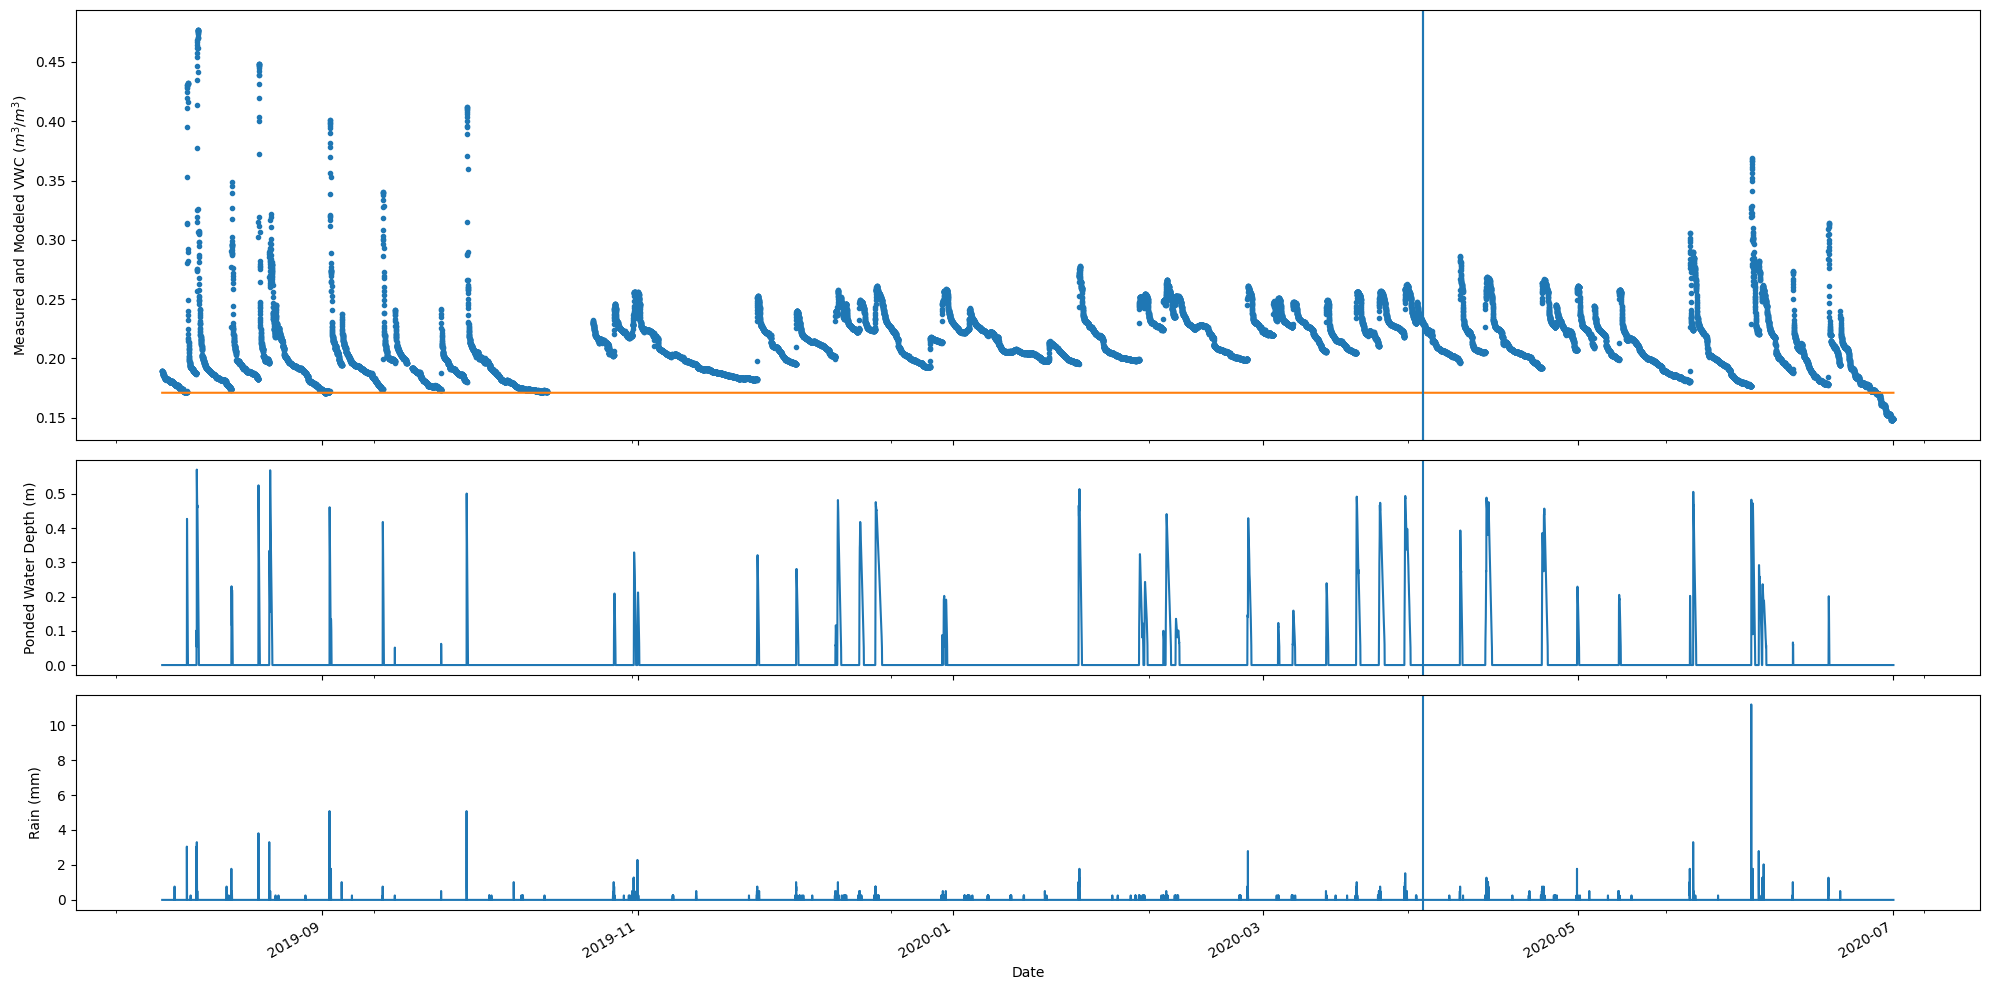

In [19]:
import datetime as dt

fig, ax = plt.subplots(3, 1,
                       figsize=(20,10),
                       sharex=True,
                       tight_layout=True,
                       height_ratios=[2, 1, 1]
)

ax[0].plot(df_out.index, df_out.P1_VWC, '.')
ax[0].axvline(dt.datetime(2020, 4, 1));
ax[0].set_ylabel("Measured and Modeled VWC $(m^3/m^3)$")

ax[0].plot(df_out.index, df_out.Forecast)
ax[0].axvline(dt.datetime(2020, 4, 1));

df["Water_Depth"].plot(ax=ax[1])
ax[1].axvline(dt.datetime(2020, 4, 1))
ax[1].set_ylabel("Ponded Water Depth (m)")

df["Rainfall_mm"].plot(ax=ax[2])
ax[2].axvline(dt.datetime(2020, 4, 1));
ax[2].set_ylabel("Rain (mm)");

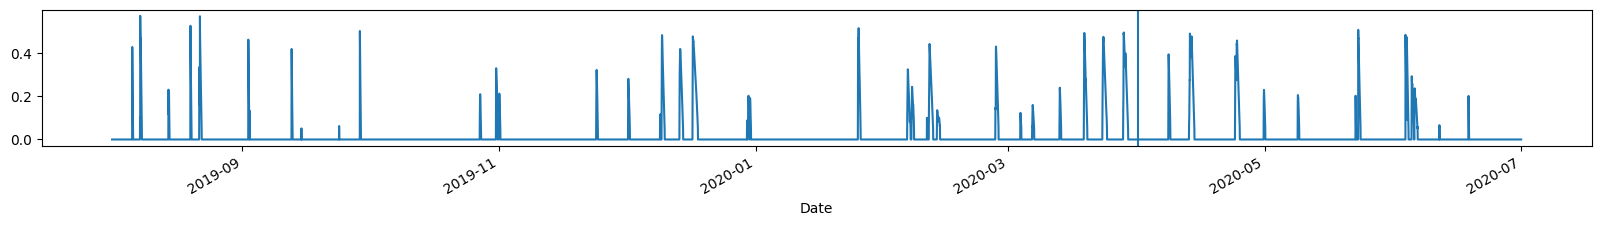

In [20]:

df["Water_Depth"].plot(figsize=(20,2))
plt.axvline(dt.datetime(2020, 4, 1));

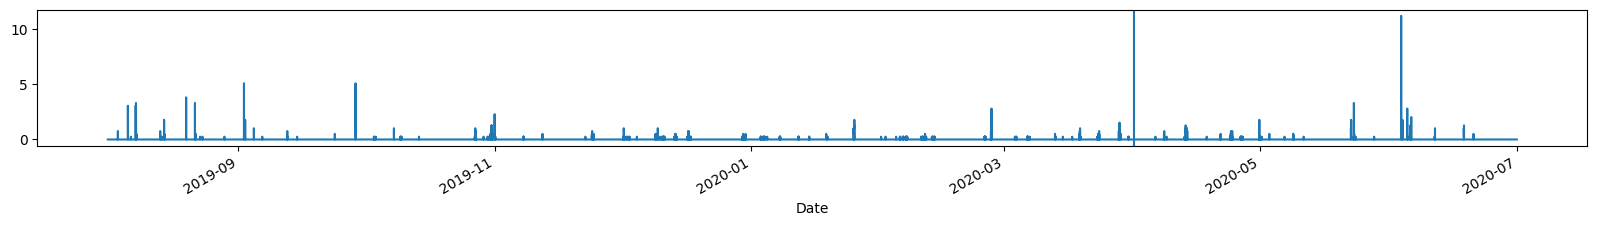

In [21]:
df["Rainfall_mm"].plot(figsize=(20,2))
plt.axvline(dt.datetime(2020, 4, 1));

In [22]:
df_out.head()

,P1_VWC,Forecast
Date,,
2019-08-01 00:00:00,0.189814,0.171073
2019-08-01 00:15:00,0.189814,0.171073
2019-08-01 00:30:00,0.189597,0.171073
2019-08-01 00:45:00,0.189597,0.171073
2019-08-01 01:00:00,0.189597,0.171073
